In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import sys

SOURCE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
sys.path.insert(0, SOURCE_DIR)

In [3]:
import malaya_speech
import malaya_speech.config
from malaya_speech.train.model import revsic_glowtts as glowtts
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt






The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [4]:
import pickle

with open('dataset-mel.pkl', 'rb') as fopen:
    data, d = pickle.load(fopen)
    
with open('dataset-mel-wav.pkl', 'rb') as fopen:
    wav = pickle.load(fopen)
    
data.keys()

dict_keys(['mel', 'text_ids', 'len_mel', 'len_text_ids', 'stop_token_target', 'f0', 'len_f0', 'energy', 'len_energy', 'g'])

In [5]:
i = tf.placeholder(tf.int32, [None, None])
i_lengths = tf.placeholder(tf.int32, [None])
mel_outputs = tf.placeholder(tf.float32, [None, None, 80])
mel_lengths = tf.placeholder(tf.int32, [None])
temperature = tf.placeholder(tf.float32, ())
length_scale = tf.placeholder(tf.float32, ())

In [6]:
config = glowtts.Config(mel = 80, vocabs = 66)
config.temperature = temperature
config.length_scale = length_scale

In [7]:
model = glowtts.Model(config)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
instance = malaya_speech.train.model.revsic_glowtts.flow.actnorm.ActNorm

for k in range(len(model.decoder.flows)):
    if isinstance(model.decoder.flows[k], instance):
        model.decoder.flows[k].init = 1

In [9]:
loss, losses, attn = model.compute_loss(text = i, textlen = i_lengths, mel = mel_outputs, mellen = mel_lengths)
loss, losses, attn

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


(<tf.Tensor 'add_4:0' shape=() dtype=float32>,
 {'nll': <tf.Tensor 'Mean:0' shape=() dtype=float32>,
  'durloss': <tf.Tensor 'Mean_1:0' shape=() dtype=float32>},
 <tf.Tensor 'StopGradient:0' shape=(?, ?, ?) dtype=float32>)

In [10]:
mel, mellen, attn_out = model(inputs = i, lengths = i_lengths, training = True)
mel, mellen, attn_out

(<tf.Tensor 'model/Reshape_50:0' shape=(?, ?, 80) dtype=float32>,
 <tf.Tensor 'model/mul_90:0' shape=(?,) dtype=int32>,
 <tf.Tensor 'model/transpose:0' shape=(?, ?, ?) dtype=float32>)

In [11]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [12]:
saver = tf.train.Saver(tf.trainable_variables())
saver.restore(sess, 'test/model.ckpt')

INFO:tensorflow:Restoring parameters from test/model.ckpt


In [15]:
model.decoder.flows[0].__dict__

{'_self_setattr_tracking': True,
 '_thread_local': <_thread._local at 0x148edb470>,
 '_name': 'act_norm',
 '_activity_regularizer': None,
 '_trainable': True,
 '_dynamic': False,
 '_is_compiled': False,
 '_layers': [],
 '_compute_output_and_mask_jointly': False,
 'supports_masking': False,
 'optimizer': None,
 '_trainable_weights': [<tf.Variable 'Variable:0' shape=(160,) dtype=float32_ref>,
  <tf.Variable 'Variable_1:0' shape=(160,) dtype=float32_ref>],
 '_non_trainable_weights': [],
 '_updates': [],
 '_losses': [],
 '_callable_losses': [],
 '_metrics': [],
 '_scope': None,
 '_reuse': None,
 '_graph': <tensorflow.python.framework.ops.Graph at 0x148d0b250>,
 '_dtype_defaulted_to_floatx': False,
 '_outbound_nodes': [],
 '_inbound_nodes': [],
 '_trackable_saver': <tensorflow.python.training.tracking.util.TrackableSaver at 0x148edd190>,
 '_is_graph_network': False,
 '_expects_training_arg': False,
 '_expects_mask_arg': True,
 '_autocast': False,
 'outputs': [<tf.Tensor 'wave_net_flow/act_n

In [17]:
sess.run(model.decoder.flows[0].mean)

array([ 0.0299217 ,  0.19960962,  0.20560375, -0.15650569, -0.36380604,
       -0.10345751,  0.07087696,  0.00522035, -0.14481053, -0.13235515,
       -0.03788777,  0.0165018 ,  0.06727644,  0.05593168,  0.01498509,
       -0.04493959, -0.10923576, -0.21821247, -0.29080167, -0.23386347,
       -0.17064199, -0.08692405, -0.01107275, -0.03613515, -0.09736277,
       -0.1057246 , -0.05382246,  0.01573698,  0.03963028,  0.02326913,
        0.02029485, -0.00150512,  0.13507879,  0.10002128, -0.04363774,
        0.04085201,  0.03625071, -0.09780262, -0.10029259, -0.1820373 ,
       -0.11201596, -0.07085683, -0.08767848,  0.02845128, -0.12590718,
       -0.21824795, -0.0272032 ,  0.15397914,  0.30798328,  0.11245985,
       -0.00079177, -0.01463543,  0.10447139,  0.01199795, -0.22843876,
       -0.41049954, -0.39303407, -0.1597876 , -0.01205103,  0.07867768,
        0.08941675,  0.07804105,  0.09109098, -0.04148684, -0.16185702,
       -0.20832643, -0.08153377, -0.09128031, -0.1697478 , -0.10

In [22]:
o = sess.run([mel, mellen, attn_out], feed_dict = {i: [data['text_ids'][0]],
                                               i_lengths: [data['len_text_ids'][0,0]],
                                                  temperature: 0.333, length_scale: 1.0})

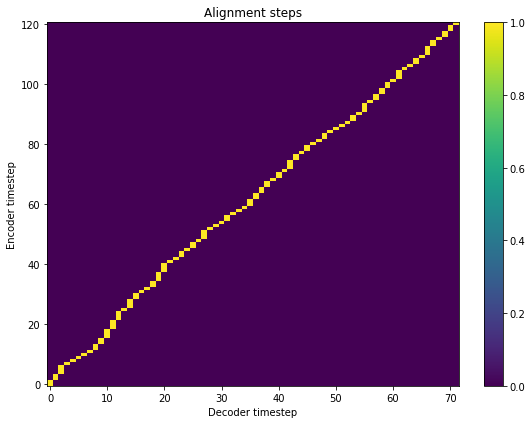

In [23]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title('Alignment steps')
im = ax.imshow(
    o[-1][0],
    aspect='auto',
    origin='lower',
    interpolation='none')
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()
plt.show()

In [24]:
o[0].shape, o[1]

((1, 242, 80), array([242], dtype=int32))

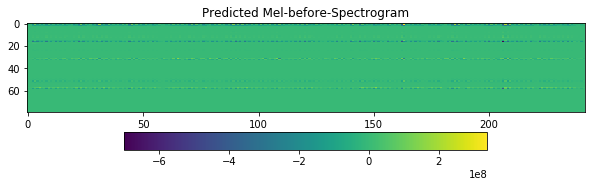

In [25]:
mel_outputs_ = np.reshape(o[0][0], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title('Alignment steps')
im = ax.imshow(
    o[-1][0],
    aspect='auto',
    origin='lower',
    interpolation='none')
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()
plt.show()